[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ahmed-h-elsheikh/FDP_2020/blob/master/UQ_v2.ipynb)

In [ ]:
# [Run in google colab](https://colab.research.google.com/github/ahmed-h-elsheikh/FDP_2020/blob/master/UQ_v2.ipynb)
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rc('text', usetex=True)
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

plt.style.use('seaborn-white')

# import seaborn as sns
# sns.set(color_codes=True)
import time
import numpy as np
from numpy import random as rand
from scipy import stats
import pandas as pd

## The following are helper functions -- generally these should be used as is

In [2]:
def data_describe(x):
    [min_value, p_1, p_10, p_50, p_90, p_99, max_value] = np.percentile(x, [0, 1, 10, 50, 90, 99, 100])
    print('========================')
    print('Number of Monte Carlo Samples: {:d}'.format(len(x)))
    print('========================')
    print('min    : {:.7e}'.format(min_value))
    print('max    : {:.7e}'.format(max_value))
    print('mean   : {:.7e}'.format(x.mean()))
    print('median : {:.7e}'.format(np.median(x)))

    print('std    : {:.7e}'.format(x.std()))
    print('========================')
    print('Data percentiles')
    print('P1  : {:.7e}'.format(p_1))
    print('P10 : {:.7e}'.format(p_10))
    print('P50 : {:.7e}'.format(p_50))
    print('P90 : {:.7e}'.format(p_90))
    print('P99 : {:.7e}'.format(p_99))
    print('========================')

def sensitivity_analysis(df, figsize=None, xlabel='Data'):
    min_value = np.inf
    max_value = -np.inf
    n_subfigures = len(df.columns)
    if figsize is None:
        figsize=(8,5*n_subfigures)
    fig, axs = plt.subplots(n_subfigures, 1, sharex=False, figsize=figsize)
    sensitivity_df = df.copy()
    for idx_ , col_ in enumerate(df.columns):
        temp_df = df.copy()
        for temp_col_ in temp_df.columns:
            if temp_col_ == col_:
                continue
            temp_df[temp_col_] = temp_df[temp_col_].mean()
        # perform the calculations on temp_df
        temp_STOIIP = calculate_STOIIP(temp_df)
        sensitivity_df[col_] = temp_STOIIP
        min_value_ = temp_STOIIP.min()
        max_value_ = temp_STOIIP.max()
        if min_value_ < min_value:
            min_value = min_value_
        if max_value_ > max_value:
            max_value = max_value_
           
        plot_distribution(temp_STOIIP, axs=axs[idx_], xlabel='{}--{}'.format(xlabel, col_))
        print('Sensitivity_analysis for {}--{}'.format(xlabel, col_))
        data_describe(temp_STOIIP)

        #axs[idx_].axvline(x=temp_STOIIP.mean(), color='r')
        #axs[idx_].axvline(x=temp_STOIIP.min(), color='b')
        #axs[idx_].axvline(x=temp_STOIIP.max(), color='b')
    slack_value = (max_value-min_value)/20 
    for idx_ , col_ in enumerate(df.columns):
        axs[idx_].set_xlim([min_value - slack_value, max_value + slack_value])
    plt.show()

    return sensitivity_df

def ordered_boxplot(sensitivity_df, xlabel='Data'):
    variations_np = []
    min_value = np.inf
    max_value = -np.inf

    for column_ in sensitivity_df.columns:
        [p_0, p_10, p_90, p_100] = np.percentile(sensitivity_df[column_].values, [0, 10, 90, 100])
        data_variation = p_90-p_10
        variations_np.append(data_variation)
        if p_0 < min_value:
            min_value = p_0
        if p_100 > max_value:
            max_value = p_100

    variations_np = np.array(variations_np)
    sort_index = np.argsort(variations_np)

    fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 6))
    new_median = sensitivity_df.mean(axis=0).values
    sensitivity_df2 = sensitivity_df.iloc[:, sort_index] 
    # axs.boxplot(sensitivity_df2.values, labels=sensitivity_df2.columns, usermedians=new_median, whis=[0, 100], vert=False)
    axs.boxplot(sensitivity_df2.values, labels=sensitivity_df2.columns, usermedians=new_median, whis=[10, 90], vert=False)
    # axs.boxplot(sensitivity_df2.values, labels=sensitivity_df2.columns, usermedians=new_median, vert=False)

    axs.axvline(x=sensitivity_df2.iloc[:,0].mean(), color='r', linewidth=2)
    axs.grid(alpha=0.75)
    # boxplot = sensitivity_df.boxplot()
    # parts = axs.violinplot(
    #         sensitivity_df, showmeans=False, showmedians=False,
    #         showextrema=False)
    slack_value = (max_value-min_value)/20 
    axs.set_xlim([min_value - slack_value, max_value + slack_value])
    axs.set_xlabel(xlabel)

    plt.show()

def plot_distribution(x, axs=None, xlim=None, ylim=None, figsize_=(15,8), bins_=100, kde_=True, cumulative_=False, xlabel='Distribution'):
    # plot the data
    if axs == None:
        fig, axs = plt.subplots(figsize=figsize_)
    axs.hist(x, density=False, bins=bins_, facecolor='b', alpha=0.5)
    axs.grid(alpha=0.75)
    axs.set_xlabel(xlabel)
    axs.set_ylabel('Count')
    axs.set_title('Histogram plot of a random variable')

    # axs.set_xlim([x.min(), x.max()])
    if xlim:
        x_min, x_max = xlim
    else:
        x_min, x_max = axs.get_xlim()
    if ylim:
        y_min, y_max = ylim
    else:
        y_min, y_max = axs.get_ylim()
    axs.set_xlim([x_min, x_max])
    axs.set_ylim([y_min, y_max])
    # axs.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.3e'))


def plot_ecdf(x, axs=None, xlim=None, ylim=None, figsize_=(15,8), bins_=100, xlabel='Data'):
    if axs == None:
        fig, axs = plt.subplots(figsize=figsize_)
    axs.hist(x,cumulative=True, density=True, bins=bins_, alpha=0.5)
    # plt.text(60, .025, '$P_{10}={:e},\\ P_{50}={:e},\\ P_90={:e}$'.format(p_10, p_50, p_90))
    axs.grid(alpha=0.75)
    axs.set_xlabel(xlabel)
    axs.set_ylabel('ECDF')
    axs.set_title('Empirical distribution function plot')
    
    if xlim:
        x_min, x_max = xlim
    else:
        x_min, x_max = axs.get_xlim()
    if ylim:
        y_min, y_max = ylim
    else:
        y_min, y_max = axs.get_ylim()
    axs.set_xlim([x_min, x_max])
    axs.set_ylim([y_min, y_max])
    

    str_shift = 0.05
    [p_10, p_50, p_90] = np.percentile(x, [10, 50, 90])
    
    axs.hlines(y=0.1, xmin=x_min, xmax=p_10)
    axs.vlines(x=p_10, ymin=0, ymax=0.1)
    text_str = "$P_{10}=" + "{:.3e}".format(p_10) + "$"
    plt.text(p_10, 0.1+str_shift, text_str,
             {'color': 'black', 'fontsize': 18, 'ha': 'center', 'va': 'center'})
    # 'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.5)})

    axs.hlines(y=0.5, xmin=x_min, xmax=p_50)
    axs.vlines(x=p_50, ymin=0, ymax=0.5)
    text_str = "$P_{50}=" + "{:.3e}".format(p_50) + "$"
    plt.text(p_50, 0.5+str_shift, text_str,
             {'color': 'black', 'fontsize': 18, 'ha': 'center', 'va': 'center'})

    axs.hlines(y=0.9, xmin=x_min, xmax=p_90)
    axs.vlines(x=p_90, ymin=0, ymax=0.9)
    text_str = "$P_{90}=" + "{:.3e}".format(p_90) + "$"
    plt.text(p_90, 0.9+str_shift, text_str,
             {'color': 'black', 'fontsize': 18, 'ha': 'center', 'va': 'center'})

    axs.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.3f'))


In [3]:
# number of Monte Carlo samples
# use the same for all Random Variables
n_samples = 1e6
n_samples = np.int64(n_samples)

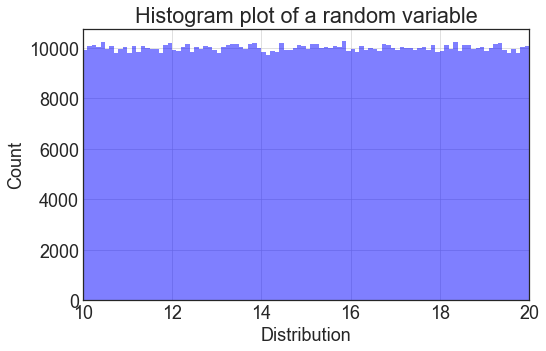

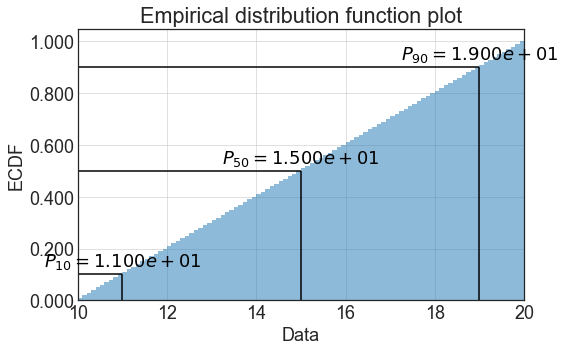

In [4]:
# random numbers from uniform distribution
lower_limit = 10
upper_limit = 20
x_uniform = rand.uniform(low=lower_limit, high=upper_limit, size=n_samples)
plot_distribution(x_uniform,figsize_=(8,5), xlim=[lower_limit, upper_limit])
plot_ecdf(x_uniform, figsize_=(8,5), xlim=[lower_limit, upper_limit])

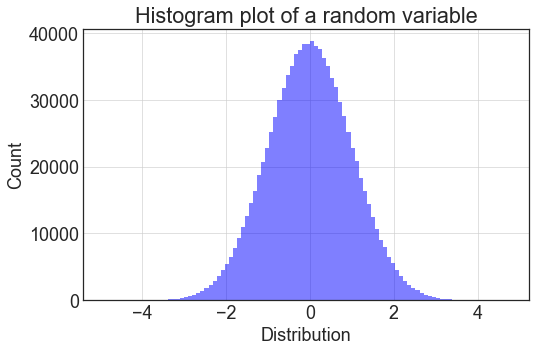

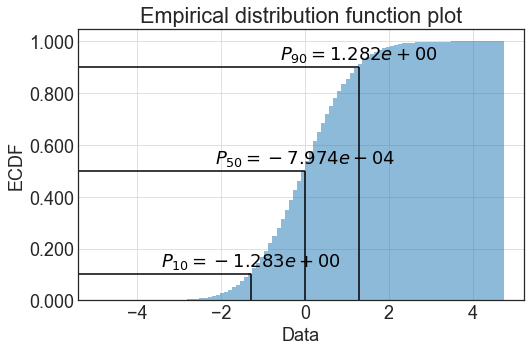

In [5]:
# generate random numbers from N(0,1)
x_mean = 0
x_std = 1
x_normal = rand.normal(loc=x_mean, scale=x_std, size=n_samples)
plot_distribution(x_normal,figsize_=(8,5))
plot_ecdf(x_normal, figsize_=(8,5))

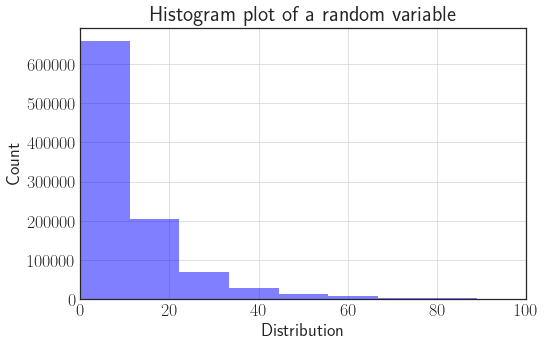

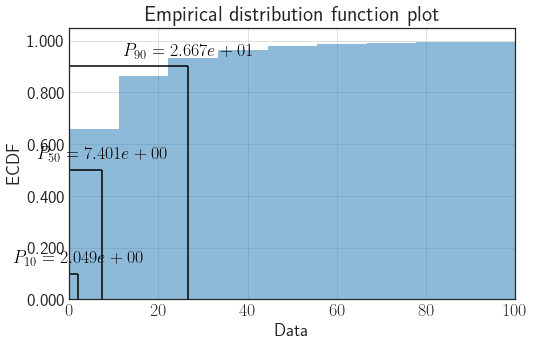

In [53]:
# generate log-normal random variable  --> always positive because it is exponential of Normal random variable 
# this distribution is defined in 
log_x_mean = 2
log_x_std = 1
x_lognormal = rand.lognormal(mean=log_x_mean, sigma=log_x_std, size=n_samples)
plot_distribution(x_lognormal,figsize_=(8,5), xlim=[0, 100])
plot_ecdf(x_lognormal, figsize_=(8,5), xlim=[0, 100])

## logarithm of lognormal should be a normal distribution

Plot the logarithm of the distribution


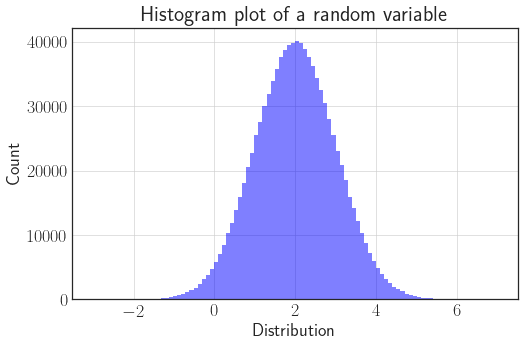

In [54]:
print('Plot the logarithm of the distribution')
plot_distribution(np.log(x_lognormal),figsize_=(8,5))

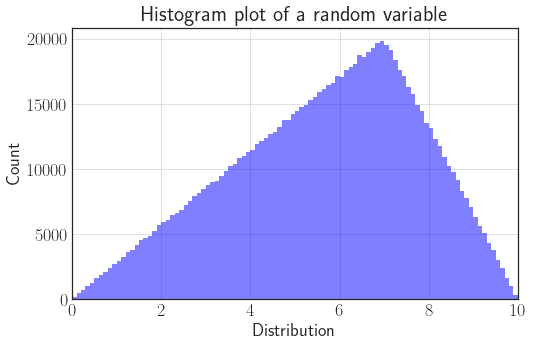

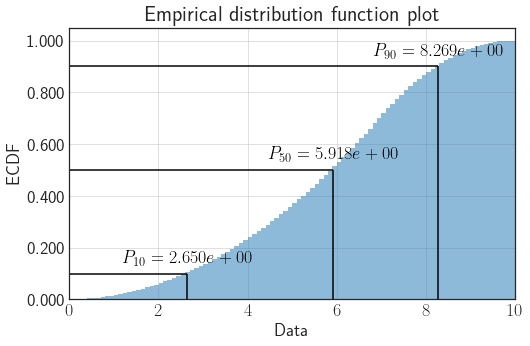

In [55]:
# generate random numbers from a triangular distribution
x_low = 0
x_mode = 7
x_high = 10
x_tri = rand.triangular(left=x_low, mode=x_mode, right=x_high, size=n_samples)
plot_distribution(x_tri,figsize_=(8,5), xlim=[x_low, x_high])
plot_ecdf(x_tri, figsize_=(8,5), xlim=[x_low, x_high])

## The following is a specific example for STOIIP calculation

In [56]:
# 1- define data distributions
Bo = rand.uniform(low=1.19, high=1.21, size=n_samples) # units Bbl/STB
Sw = rand.uniform(low=0.19, high=0.45, size=n_samples)
porosity = rand.triangular(left=0.17, mode=0.213, right=0.24, size=n_samples)
GRV = rand.triangular(left=0.55, mode=0.64, right=0.72, size=n_samples) # units 10^9 m3

In [57]:
# 2- put your data into named tuples in a pandas.DataFrame 
data_df = pd.DataFrame()
data_df['GRV'] = GRV
data_df['porosity'] = porosity
data_df['Sw'] = Sw
data_df['Bo'] = Bo

In [58]:
# 3- define your calculation inside a function with data
# http://www.oilfieldwiki.com/wiki/Oil_in_place
# perform Monte Carlo simulation on the random variables 
# define the calculations needed
def calculate_STOIIP(data_df):
    STOIIP = 7758 * (data_df['GRV'] * 1e9) * data_df['porosity']  * (1 - data_df['Sw']) / data_df['Bo'] # units barrels
    return STOIIP

finished MC calucation of STOIIP in 0.0 sec
Number of Monte Carlo Samples: 1000000
min    : 3.3988431e+11
max    : 8.8203904e+11
mean   : 5.8130020e+11
median : 5.7742186e+11
std    : 8.2363538e+10
Data percentiles
P1  : 4.1643876e+11
P10 : 4.7596172e+11
P50 : 5.7742186e+11
P90 : 6.9274620e+11
P99 : 7.7204973e+11


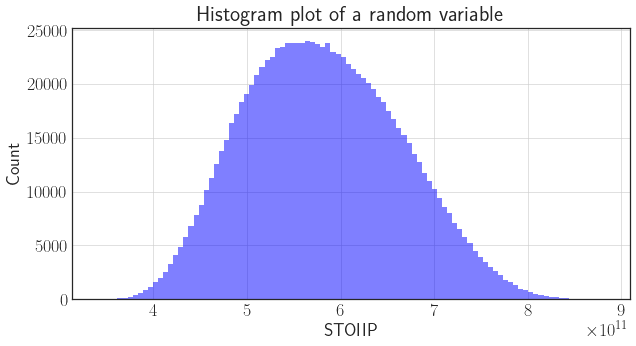

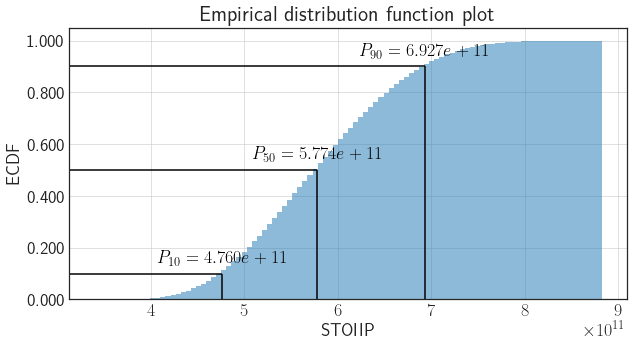

In [59]:
# perform analysis
t0 = time.time()
STOIIP = calculate_STOIIP(data_df)

print('finished MC calucation of STOIIP in {} sec'.format(time.time()-time.time()))
data_describe(STOIIP)
plot_distribution(STOIIP, figsize_=(10,5), xlabel='STOIIP')
plot_ecdf(STOIIP, figsize_=(10,5), xlabel='STOIIP')

Sensitivity_analysis for STOIIP--GRV
Number of Monte Carlo Samples: 1000000
min    : 5.0226930e+11
max    : 6.5732604e+11
mean   : 5.8129039e+11
median : 5.8206993e+11
std    : 3.1705156e+10
Data percentiles
P1  : 5.1350569e+11
P10 : 5.3780858e+11
P50 : 5.8206993e+11
P90 : 6.2367797e+11
P99 : 6.4667753e+11
Sensitivity_analysis for STOIIP--porosity
Number of Monte Carlo Samples: 1000000
min    : 4.7588711e+11
max    : 6.7167798e+11
mean   : 5.8129039e+11
median : 5.8440995e+11
std    : 4.0329535e+10
Data percentiles
P1  : 4.9137406e+11
P10 : 5.2446616e+11
P50 : 5.8440995e+11
P90 : 6.3333837e+11
P99 : 6.5956329e+11
Sensitivity_analysis for STOIIP--Sw
Number of Monte Carlo Samples: 1000000
min    : 4.7013427e+11
max    : 6.9237915e+11
mean   : 5.8129039e+11
median : 5.8135386e+11
std    : 6.4133685e+10
Data percentiles
P1  : 4.7236830e+11
P10 : 4.9238572e+11
P50 : 5.8135386e+11
P90 : 6.7010937e+11
P99 : 6.9010959e+11
Sensitivity_analysis for STOIIP--Bo
Number of Monte Carlo Samples: 10000

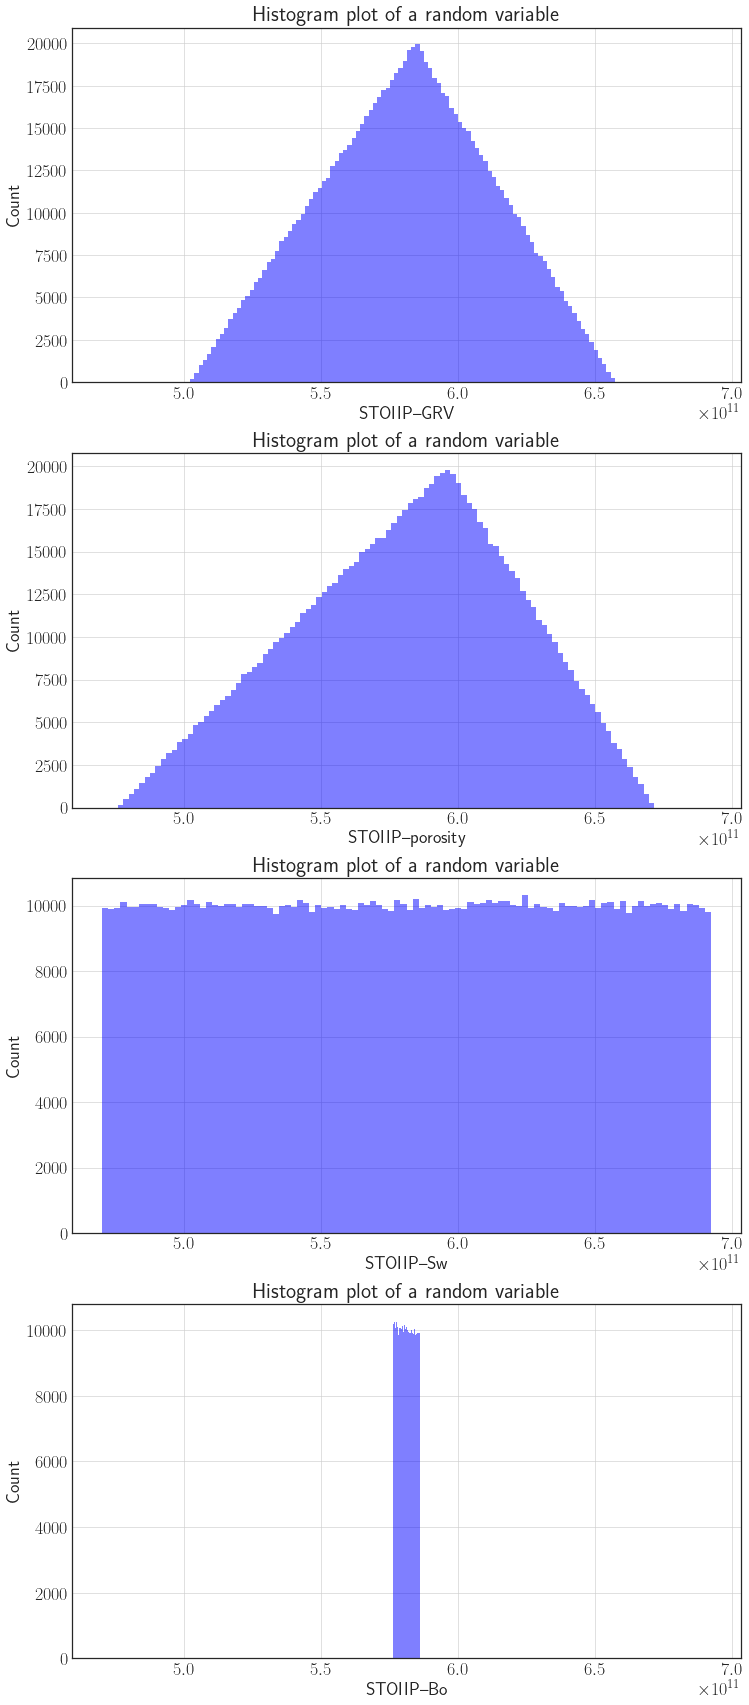

In [60]:
sensitivity_df = sensitivity_analysis(data_df, figsize=(12,6*5), xlabel='STOIIP')

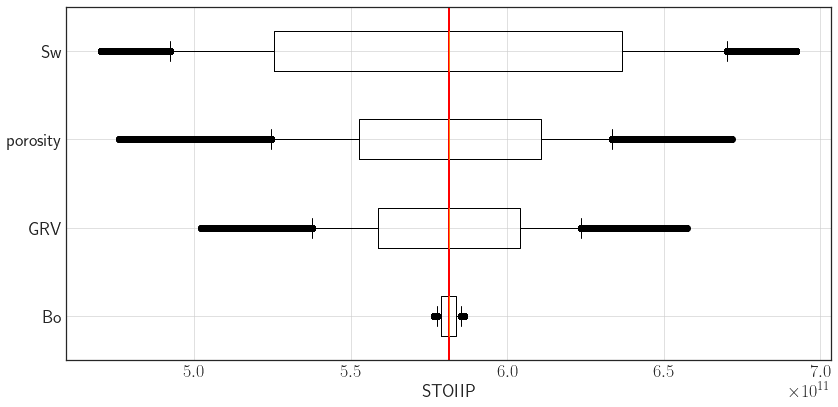

In [61]:
ordered_boxplot(sensitivity_df, xlabel='STOIIP')